LODF: 100%|██████████| 6/6 [00:00<00:00, 833.28it/s]



=== EDGE RANKING (highest → most critical) ===
            line  radius_L2  load_ratio  influence_LODF    CCI
0      Bus1-Bus2     51.033       0.643             1.0  0.600
1      Bus1-Bus3     62.913       0.511             1.0  0.536
2      Bus2-Bus4     83.704       0.464             1.0  0.513
3      Bus3-Bus4     97.051       0.326             1.0  0.446
4  Bus4-SlackBus     65.974       0.224             1.0  0.396
5  Bus1-SlackBus     89.610       0.026             1.0  0.300

=== NODE RANKING ===
        bus  abs_injection  Criticality
0      Bus1            100          NaN
1      Bus2            120          NaN
2      Bus3             80          NaN
3      Bus4             50          NaN
4  SlackBus             50          NaN

Графики сохранены в edge_criticality.png и network_criticality.png


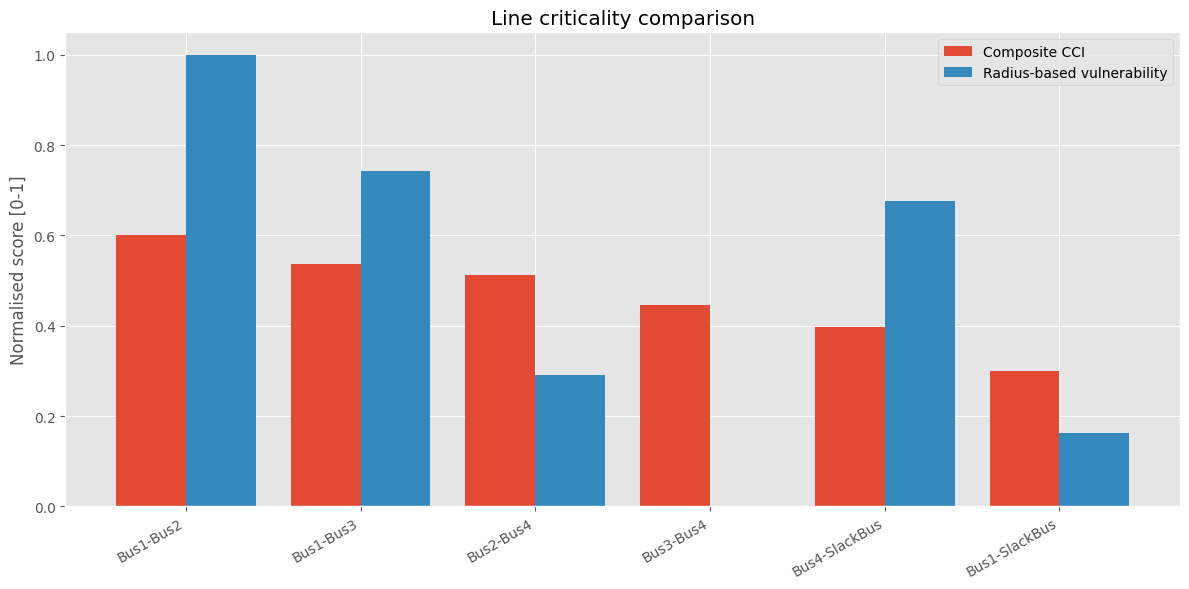

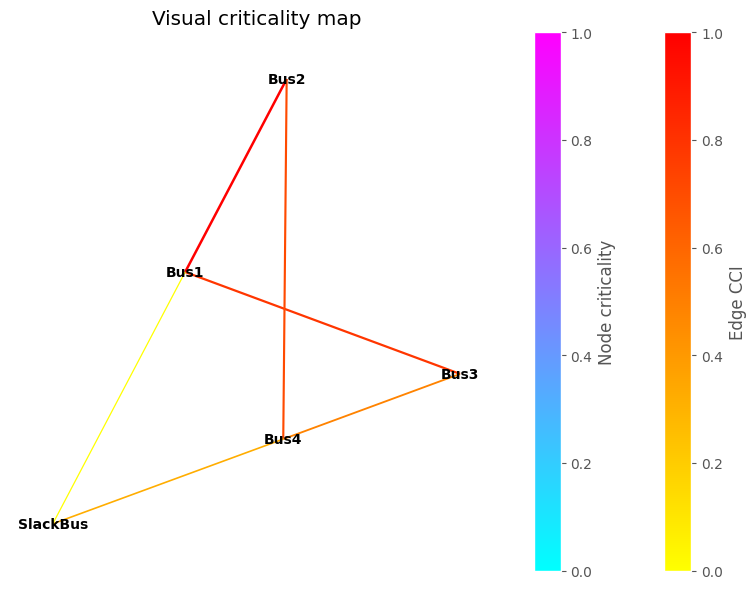

In [4]:
import networkx as nx
import numpy as np
import scipy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


# --------------------------------------------------------------------------- #
# 1.  MODEL & POWER-FLOW HELPERS
# --------------------------------------------------------------------------- #
def create_distributed_energy_network() -> nx.Graph:
    """
    Very small 5-bus test case with two generators + slack.
    Capacities and reactances picked for illustration only.
    """
    G = nx.Graph()

    # Node injections (MW). Slack gen filled later to balance ΣP = 0
    buses = {
        "Bus1": {"generation": 150, "load": 50},
        "Bus2": {"generation": 0, "load": 120},
        "Bus3": {"generation": 0, "load": 80},
        "Bus4": {"generation": 100, "load": 50},
        "SlackBus": {"generation": 0, "load": 0},
    }
    net = sum(d["generation"] - d["load"] for d in buses.values())
    buses["SlackBus"]["generation"] = -net

    for n, data in buses.items():
        G.add_node(n, **data)

    # Lines: capacity [MW] & reactance [p.u.]
    G.add_edges_from(
        [
            ("Bus1", "Bus2", {"capacity": 100, "reactance": 0.10}),
            ("Bus1", "Bus3", {"capacity": 80, "reactance": 0.125}),
            ("Bus2", "Bus4", {"capacity": 120, "reactance": 0.08}),
            ("Bus3", "Bus4", {"capacity": 120, "reactance": 0.08}),
            ("SlackBus", "Bus1", {"capacity": 200, "reactance": 0.05}),
            ("SlackBus", "Bus4", {"capacity": 200, "reactance": 0.05}),
        ]
    )
    return G


def build_susceptance_matrix(G: nx.Graph, nodes: list[str]) -> np.ndarray:
    """Laplacian of susceptances (B-matrix)"""
    n = len(nodes)
    B = np.zeros((n, n))
    idx = {n: i for i, n in enumerate(nodes)}
    for u, v, dat in G.edges(data=True):
        b = 1.0 / dat["reactance"]
        i, j = idx[u], idx[v]
        B[i, i] += b
        B[j, j] += b
        B[i, j] -= b
        B[j, i] -= b
    return B


def compute_ptdf(G: nx.Graph, nodes: list[str], slack_idx: int) -> dict[tuple[str, str], dict]:
    """
    PTDF[i,j][(u,v)]  — transfer from i→j (MW) → %flow on (u,v)/MW
    For tiny systems store in dict of dicts to stay clear.
    """
    n = len(nodes)
    non_slack = [k for k in range(n) if k != slack_idx]
    B = build_susceptance_matrix(G, nodes)
    B_red = B[np.ix_(non_slack, non_slack)]
    X = np.zeros_like(B)
    X[np.ix_(non_slack, non_slack)] = la.inv(B_red)

    ptdf: dict = {}
    idx = {n: i for i, n in enumerate(nodes)}
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            key = (nodes[i], nodes[j])
            ptdf[key] = {}
            for u, v, dat in G.edges(data=True):
                b = 1.0 / dat["reactance"]
                iu, iv = idx[u], idx[v]
                ptdf[key][(u, v)] = b * (
                    X[iu, i] - X[iu, j] - X[iv, i] + X[iv, j]
                )
    return ptdf


def compute_lodf(G: nx.Graph, ptdf: dict) -> dict[tuple[tuple[str, str], tuple[str, str]], float]:
    """
    LODF[(m,line k)]  — fraction of flow on m caused by outage of k.
    """
    lodf = {}
    edges = [(u, v) for u, v, _ in G.edges(data=True)]
    for k in tqdm(edges, desc="LODF"):
        k_from, k_to = k
        key = (k_from, k_to) if (k_from, k_to) in ptdf else (k_to, k_from)
        ptdf_kk = ptdf[key][k] if k in ptdf[key] else ptdf[key][(k_to, k_from)]
        if abs(1 - ptdf_kk) < 1e-9:
            continue  # islanding
        denom = 1 - ptdf_kk
        for m in edges:
            if m == k:
                continue
            lodf[(m, k)] = ptdf[key][m] / denom
    return lodf


def dc_power_flow(G: nx.Graph, nodes: list[str], slack_idx: int) -> dict[tuple[str, str], float]:
    """Base-case flows (MW, sign per u→v)"""
    B = build_susceptance_matrix(G, nodes)
    non_slack = [k for k in range(len(nodes)) if k != slack_idx]
    B_red = B[np.ix_(non_slack, non_slack)]
    P = np.array(
        [
            G.nodes[n]["generation"] - G.nodes[n]["load"]
            for n in nodes
            if n != nodes[slack_idx]
        ]
    )
    theta = la.solve(B_red, P)
    theta = np.insert(theta, slack_idx, 0.0)
    idx = {n: i for i, n in enumerate(nodes)}

    flows = {}
    for u, v, dat in G.edges(data=True):
        b = 1.0 / dat["reactance"]
        flows[(u, v)] = b * (theta[idx[u]] - theta[idx[v]])
    return flows


# --------------------------------------------------------------------------- #
# 2.  METRICS
# --------------------------------------------------------------------------- #
def stability_radius_L2(G, nodes, slack, ptdf, flows):
    """
    Improved radius:  L2-norm of minimally balanced injection ΔP
    that overloads each line.
    """
    non_slack = [n for n in nodes if n != slack]
    lines = [(u, v) for u, v, _ in G.edges(data=True)]

    # Build PTDF matrix H: rows – lines, cols – nodes≠slack
    H = np.zeros((len(lines), len(non_slack)))
    for r, (u, v) in enumerate(lines):
        for c, bus in enumerate(non_slack):
            H[r, c] = ptdf[(bus, slack)][(u, v)]

    # Add balancing on slack: col = –Σ PTDF(row)
    H_bal = np.hstack([H, -H.sum(axis=1, keepdims=True)])

    margin = np.array(
        [
            G[u][v]["capacity"] - abs(flows[(u, v)])
            for r, (u, v) in enumerate(lines)
        ]
    )
    # L2 radius (MW)
    radius = margin / np.linalg.norm(H_bal, axis=1)
    return dict(zip(lines, radius))


def classic_edge_metrics(G, flows, lodf):
    lines = [(u, v) for u, v, _ in G.edges(data=True)]

    # 1) Load ratio |F|/capacity
    load_ratio = {l: abs(flows[l]) / G[l[0]][l[1]]["capacity"] for l in lines}

    # 2) Influence: max |LODF| caused by outage of l
    influence = {}
    for l in lines:
        inf = max(abs(lodf.get((m, l), 0.0)) for m in lines if m != l)
        influence[l] = inf

    # 3) Topological betweenness (just for flavour)
    bet = nx.edge_betweenness_centrality(G, normalized=True, weight=None)
    bet = {tuple(sorted(k)): v for k, v in bet.items()}

    return load_ratio, influence, bet


def classic_node_metrics(G):
    """Betweenness + net injection magnitude"""
    inj = {n: abs(G.nodes[n]["generation"] - G.nodes[n]["load"]) for n in G.nodes}
    bet = nx.betweenness_centrality(G, normalized=True, weight=None)
    return inj, bet


def normalise(series, invert=False):
    a = np.asarray(list(series.values()), dtype=float)
    if np.allclose(a.max(), a.min()):
        res = np.full_like(a, 0.5)
    else:
        res = (a - a.min()) / (a.max() - a.min())
    if invert:
        res = 1 - res
    return dict(zip(series.keys(), res))


# --------------------------------------------------------------------------- #
# 3.  MAIN ANALYSIS PIPELINE
# --------------------------------------------------------------------------- #
def main():
    # ------------------- build model & base flow ----------------------------
    G = create_distributed_energy_network()
    nodes = sorted(G.nodes())  # deterministic
    slack = "SlackBus"
    slack_idx = nodes.index(slack)

    ptdf = compute_ptdf(G, nodes, slack_idx)
    lodf = compute_lodf(G, ptdf)
    flows = dc_power_flow(G, nodes, slack_idx)

    # ------------------- metrics -------------------------------------------
    sr = stability_radius_L2(G, nodes, slack, ptdf, flows)
    load_ratio, infl, bet_e = classic_edge_metrics(G, flows, lodf)
    inj_node, bet_v = classic_node_metrics(G)

    # ------------------- build DataFrame for edges -------------------------
    df_e = pd.DataFrame(
        {
            "line": [f"{u}-{v}" for u, v in sr.keys()],
            "radius_L2": list(sr.values()),
            "load_ratio": list(load_ratio.values()),
            "influence_LODF": list(infl.values()),
            "betweenness": [bet_e.get(tuple(sorted(k)), 0.0) for k in sr.keys()],
        }
    )

    # normalised [0,1] (invert radius → vulnerability score)
    # df_e["score_radius"] = pd.Series(normalise(sr, invert=True))
    score_radius = normalise(sr, invert=True)
    df_e["score_radius"] = df_e["line"].map(lambda x: score_radius[tuple(x.split("-"))])

    # df_e["score_load"] = pd.Series(normalise(load_ratio))
    # df_e["score_influence"] = pd.Series(normalise(infl))
    # df_e["score_bet"] = pd.Series(normalise(bet_e))

    score_load = normalise(load_ratio)
    df_e["score_load"] = df_e["line"].map(lambda x: score_load[tuple(x.split("-"))])

    score_infl = normalise(infl)
    df_e["score_influence"] = df_e["line"].map(lambda x: score_infl[tuple(x.split("-"))])

    score_bet = normalise(bet_e)
    df_e["score_bet"] = df_e["line"].map(lambda x: score_bet.get(tuple(sorted(x.split("-"))), 0.0))


    # composite criticality index
    w = {"radius": 0, "load": 0.3, "infl": 0.3, "bet": 0.3}
    df_e["CCI"] = (
        w["radius"] * df_e["score_radius"]
        + w["load"] * df_e["score_load"]
        + w["infl"] * df_e["score_influence"]
        + w["bet"] * df_e["score_bet"]
    )
    df_e.sort_values("CCI", ascending=False, inplace=True, ignore_index=True)

    # ------------------- build DataFrame for nodes -------------------------
    df_v = pd.DataFrame(
        {
            "bus": list(inj_node.keys()),
            "abs_injection": list(inj_node.values()),
            "betweenness": list(bet_v.values()),
        }
    )
    df_v["score_inj"] = pd.Series(normalise(inj_node))
    df_v["score_bet"] = pd.Series(normalise(bet_v))
    df_v["Criticality"] = 0.6 * df_v["score_inj"] + 0.4 * df_v["score_bet"]
    df_v.sort_values("Criticality", ascending=False, inplace=True, ignore_index=True)

    # ------------------- console output ------------------------------------
    pd.set_option("display.width", 120)
    print("\n=== EDGE RANKING (highest → most critical) ===")
    print(
        df_e[
            ["line", "radius_L2", "load_ratio", "influence_LODF", "CCI"]
        ].round(3)
    )
    print("\n=== NODE RANKING ===")
    print(df_v[["bus", "abs_injection", "Criticality"]].round(3))

    # ---------------------------------------------------------------------- #
    # 4.  VISUALISATION
    # ---------------------------------------------------------------------- #
    plt.style.use("ggplot")

    # (a) Bar chart – composite vs radius
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(df_e))
    ax.bar(x - 0.2, df_e["CCI"], width=0.4, label="Composite CCI")
    ax.bar(x + 0.2, df_e["score_radius"], width=0.4, label="Radius-based vulnerability")
    ax.set_xticks(x)
    ax.set_xticklabels(df_e["line"], rotation=30, ha="right")
    ax.set_ylabel("Normalised score [0-1]")
    ax.set_title("Line criticality comparison")
    ax.legend()
    plt.tight_layout()
    plt.savefig("edge_criticality.png", dpi=150)

    # (b) Network plot with node/edge sizes
    pos = nx.spring_layout(G, seed=7)
    fig2, ax2 = plt.subplots(figsize=(8, 6))
    # Edge colours by CCI
    cci_edge = {tuple(sorted(k.split("-"))): v for k, v in zip(df_e["line"], df_e["CCI"])}
    edges, cci = zip(*cci_edge.items())
    nx.draw_networkx_edges(
        G,
        pos,
        edgelist=edges,
        edge_color=cci,
        edge_cmap=plt.cm.autumn_r,
        width=[3 * x for x in cci],
    )
    # Node sizes by criticality
    crit = {r.bus: r.Criticality for r in df_v.itertuples()}
    nx.draw_networkx_nodes(
        G,
        pos,
        node_size=[600 + 1200 * crit[n] for n in G.nodes],
        node_color=list(crit.values()),
        cmap=plt.cm.cool,
    )
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
    sm_e = plt.cm.ScalarMappable(cmap=plt.cm.autumn_r, norm=plt.Normalize(0, 1))
    sm_n = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(0, 1))
    plt.colorbar(sm_e, ax=ax2, label="Edge CCI")
    plt.colorbar(sm_n, ax=ax2, label="Node criticality")
    ax2.set_axis_off()
    ax2.set_title("Visual criticality map")
    plt.tight_layout()
    # plt.savefig("network_criticality.png", dpi=150)

    print("\nГрафики сохранены в edge_criticality.png и network_criticality.png")


# --------------------------------------------------------------------------- #
if __name__ == "__main__":
    main()


In [6]:
import argparse
import importlib
import numpy as np
import pandas as pd
import networkx as nx
import scipy.stats as st

# Импортируем функции из вашего основного скрипта
# sa = importlib.import_module("stability_analysis")  # имя файла без .py


# --------------------------------------------------------------------------- #
# 1. Test-case generators
# --------------------------------------------------------------------------- #
def create_radial_network() -> nx.Graph:
    """6 ш шин, радикальная структура"""
    G = nx.Graph()
    for i in range(6):
        G.add_node(f"B{i+1}", generation=0, load=50)
    G.nodes["B1"]["generation"] = 300  # источник
    G.add_node("SlackBus", generation=-50, load=0)
    edges = [
        ("B1", "B2", 0.12, 120),
        ("B2", "B3", 0.10, 100),
        ("B3", "B4", 0.10, 80),
        ("B4", "B5", 0.08, 80),
        ("B5", "B6", 0.08, 60),
        ("B1", "SlackBus", 0.05, 200),
    ]
    for u, v, x, c in edges:
        G.add_edge(u, v, reactance=x, capacity=c)
    return G


def create_meshed_network() -> nx.Graph:
    """8 узлов, кольцевая сеть"""
    G = nx.Graph()
    data = {
        "N1": (100, 20),
        "N2": (0, 40),
        "N3": (0, 60),
        "N4": (50, 10),
        "N5": (0, 40),
        "N6": (0, 70),
        "N7": (0, 40),
        "SlackBus": (0, 0),
    }
    for n, (gen, load) in data.items():
        G.add_node(n, generation=gen, load=load)
    gen_total = sum(g - l for g, l in data.values())
    G.nodes["SlackBus"]["generation"] = -gen_total

    edges = [
        ("N1", "N2", 0.15, 120),
        ("N2", "N3", 0.12, 100),
        ("N3", "N4", 0.10, 100),
        ("N4", "N5", 0.10, 100),
        ("N5", "N6", 0.08, 100),
        ("N6", "N7", 0.08, 100),
        ("N7", "N1", 0.15, 120),
        ("N2", "N6", 0.12, 90),
        ("SlackBus", "N1", 0.05, 250),
        ("SlackBus", "N4", 0.05, 250),
    ]
    for u, v, x, c in edges:
        G.add_edge(u, v, reactance=x, capacity=c)
    return G


# --------------------------------------------------------------------------- #
# 2. Monte-Carlo overload experiment
# --------------------------------------------------------------------------- #
def monte_carlo_overload(
    G: nx.Graph,
    slack: str,
    n_sim: int = 2000,
    sigma: float = 0.25,
    seed: int | None = 7,
) -> dict:
    """
    Случайно возмущаем инъекции (нормальное распределение, σ= sigma*|P_base|),
    ребалансируем через SlackBus. Считаем частоту перегрузок каждой линии.
    """
    rng = np.random.default_rng(seed)
    nodes = list(G.nodes)
    lines = [(u, v) for u, v in G.edges]
    counts = {l: 0 for l in lines}

    # Базовые значения
    base_gen = {n: G.nodes[n]["generation"] for n in nodes}
    base_load = {n: G.nodes[n]["load"] for n in nodes}

    for _ in range(n_sim):
        # 1) Переброс инъекций (не трогаем Slack)
        for n in nodes:
            if n == slack:
                continue
            base = base_gen[n] - base_load[n]
            noise = rng.normal(0, sigma * max(abs(base), 1))
            if base >= 0:  # генератор
                G.nodes[n]["generation"] = max(0, base_gen[n] + noise)
            else:  # чистая нагрузка
                G.nodes[n]["load"] = max(0, base_load[n] - noise)

        # 2) Балансируем Slack
        net = sum(
            G.nodes[n]["generation"] - G.nodes[n]["load"]
            for n in nodes
            if n != slack
        )
        G.nodes[slack]["generation"] = -net

        # 3) Флоу + проверка
        flows = dc_power_flow(G, nodes, nodes.index(slack))
        for l in lines:
            if abs(flows[l]) > G[l[0]][l[1]]["capacity"]:
                counts[l] += 1

        # 4) Откат
        for n in nodes:
            G.nodes[n]["generation"] = base_gen[n]
            G.nodes[n]["load"] = base_load[n]

    freq = {l: counts[l] / n_sim for l in lines}
    return freq


# --------------------------------------------------------------------------- #
# 3. One-shot routine: compute rank-correlation radius ↔ overload frequency
# --------------------------------------------------------------------------- #
def evaluate_network(G: nx.Graph, name: str):
    nodes = sorted(G.nodes)
    slack = next(n for n in nodes if "Slack" in n)
    slack_idx = nodes.index(slack)

    # «Золотые» метрики
    ptdf = compute_ptdf(G, nodes, slack_idx)
    flows_base = dc_power_flow(G, nodes, slack_idx)
    radius = stability_radius_L2(G, nodes, slack, ptdf, flows_base)
    # Monte-Carlo факт
    freq = monte_carlo_overload(G, slack, n_sim=3000, sigma=0.3)

    # ранги
    rad_rank = pd.Series(radius).rank(method="average", ascending=True)
    freq_rank = pd.Series(freq).rank(method="average", ascending=False)

    rho, p = st.spearmanr(rad_rank, freq_rank)
    print(f"\n=== {name} ===")
    print("Spearman ρ(radius ↓, freq ↑) = {:.3f}  (p = {:.3g})".format(rho, p))
    # Топ-k хит-рейт (k = ⌈30 %⌉)
    k = max(1, int(0.3 * len(rad_rank)))
    top_rad = set(rad_rank.nsmallest(k).index)
    top_freq = set(freq_rank.nsmallest(k).index)
    hits = len(top_rad & top_freq) / k
    print(f"Top-{k} hit-rate = {hits:.2%}")

    # Для удобства сведём в таблицу
    df = pd.DataFrame(
        {
            "line": [f"{u}-{v}" for u, v in radius],
            "radius": list(radius.values()),
            "overload_freq": [freq[l] for l in radius],
        }
    ).sort_values("radius")
    print(df.head(k).round(4))


# --------------------------------------------------------------------------- #
if __name__ == "__main__":

    evaluate_network(create_distributed_energy_network(), "Default 5-bus")
    evaluate_network(create_radial_network(), "Radial 6-bus")
    evaluate_network(create_meshed_network(), "Meshed 8-bus")



=== Default 5-bus ===
Spearman ρ(radius ↓, freq ↑) = 0.507  (p = 0.305)
Top-1 hit-rate = 100.00%
        line  radius  overload_freq
0  Bus1-Bus2  51.033          0.017

=== Radial 6-bus ===
Spearman ρ(radius ↓, freq ↑) = 0.986  (p = 0.000309)
Top-1 hit-rate = 100.00%
    line   radius  overload_freq
0  B1-B2 -23.7346            1.0

=== Meshed 8-bus ===
Spearman ρ(radius ↓, freq ↑) = 0.701  (p = 0.024)
Top-3 hit-rate = 66.67%
          line   radius  overload_freq
6        N4-N5  19.8010         0.0023
5        N3-N4  26.9418         0.0007
7  N4-SlackBus  40.6460         0.0000


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Unified module: stability metrics + automatic tests
author : ChatGPT-o3 (2025-07-27)
"""

# --------------------------------------------------------------------------- #
# 0.  IMPORTS & GLOBALS
# --------------------------------------------------------------------------- #
from __future__ import annotations

import argparse
import math
import sys
from pathlib import Path
from typing import Dict, List, Tuple

import networkx as nx
import numpy as np
import pandas as pd
import scipy.linalg as la
import scipy.stats as st
from tqdm import tqdm

try:                    # AUC (опционально)
    from sklearn.metrics import roc_auc_score
    HAVE_SKLEARN = True
except ModuleNotFoundError:
    HAVE_SKLEARN = False

import matplotlib.pyplot as plt

# prettier matplotlib
plt.rcParams.update(
    {"figure.dpi": 110, "axes.grid": True, "grid.alpha": 0.25, "font.size": 11}
)


# --------------------------------------------------------------------------- #
# 1.  NETWORK BUILDERS
# --------------------------------------------------------------------------- #
def create_default_5bus() -> nx.Graph:
    """Сеть из примера (5 шин, 6 линий)."""
    G = nx.Graph()
    buses = {
        "Bus1": (150, 50),
        "Bus2": (0, 120),
        "Bus3": (0, 80),
        "Bus4": (100, 50),
        "SlackBus": (0, 0),
    }
    for n, (g, l) in buses.items():
        G.add_node(n, generation=g, load=l)
    net = sum(g - l for g, l in buses.values())
    G.nodes["SlackBus"]["generation"] = -net
    edges = [
        ("Bus1", "Bus2", 0.10, 100),
        ("Bus1", "Bus3", 0.125, 80),
        ("Bus2", "Bus4", 0.08, 120),
        ("Bus3", "Bus4", 0.08, 120),
        ("SlackBus", "Bus1", 0.05, 200),
        ("SlackBus", "Bus4", 0.05, 200),
    ]
    for u, v, x, c in edges:
        G.add_edge(u, v, reactance=x, capacity=c)
    return G


def create_radial_6bus() -> nx.Graph:
    """Радиальная 6-узловая сеть."""
    G = nx.Graph()
    for i in range(6):
        G.add_node(f"B{i+1}", generation=0, load=50)
    G.nodes["B1"]["generation"] = 300  # источник
    G.add_node("SlackBus", generation=-50, load=0)
    edges = [
        ("B1", "B2", 0.12, 120),
        ("B2", "B3", 0.10, 100),
        ("B3", "B4", 0.10, 80),
        ("B4", "B5", 0.08, 80),
        ("B5", "B6", 0.08, 60),
        ("B1", "SlackBus", 0.05, 200),
    ]
    for u, v, x, c in edges:
        G.add_edge(u, v, reactance=x, capacity=c)
    return G


def create_meshed_8bus() -> nx.Graph:
    """Кольцевая 8-узловая сеть."""
    G = nx.Graph()
    data = {
        "N1": (100, 20),
        "N2": (0, 40),
        "N3": (0, 60),
        "N4": (50, 10),
        "N5": (0, 40),
        "N6": (0, 70),
        "N7": (0, 40),
        "SlackBus": (0, 0),
    }
    for n, (g, l) in data.items():
        G.add_node(n, generation=g, load=l)
    net = sum(g - l for g, l in data.values())
    G.nodes["SlackBus"]["generation"] = -net
    edges = [
        ("N1", "N2", 0.15, 120),
        ("N2", "N3", 0.12, 100),
        ("N3", "N4", 0.10, 100),
        ("N4", "N5", 0.10, 100),
        ("N5", "N6", 0.08, 100),
        ("N6", "N7", 0.08, 100),
        ("N7", "N1", 0.15, 120),
        ("N2", "N6", 0.12, 90),
        ("SlackBus", "N1", 0.05, 250),
        ("SlackBus", "N4", 0.05, 250),
    ]
    for u, v, x, c in edges:
        G.add_edge(u, v, reactance=x, capacity=c)
    return G


GRID_FACTORY = {
    "default": create_default_5bus,
    "radial": create_radial_6bus,
    "meshed": create_meshed_8bus,
}


# --------------------------------------------------------------------------- #
# 2.  POWER-FLOW UTILITIES (DC)
# --------------------------------------------------------------------------- #
def build_B(G: nx.Graph, nodes: List[str]) -> np.ndarray:
    n = len(nodes)
    B = np.zeros((n, n))
    idx = {n: i for i, n in enumerate(nodes)}
    for u, v, dat in G.edges(data=True):
        b = 1.0 / dat["reactance"]
        i, j = idx[u], idx[v]
        B[i, i] += b
        B[j, j] += b
        B[i, j] -= b
        B[j, i] -= b
    return B


def compute_ptdf(
    G: nx.Graph, nodes: List[str], slack_idx: int
) -> Dict[Tuple[str, str], Dict[Tuple[str, str], float]]:
    n = len(nodes)
    non_slack = [k for k in range(n) if k != slack_idx]
    B = build_B(G, nodes)
    B_red = B[np.ix_(non_slack, non_slack)]
    X = np.zeros_like(B)
    X[np.ix_(non_slack, non_slack)] = la.inv(B_red)

    idx = {n: i for i, n in enumerate(nodes)}
    ptdf: dict = {}
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            key = (nodes[i], nodes[j])
            ptdf[key] = {}
            for u, v, dat in G.edges(data=True):
                b = 1.0 / dat["reactance"]
                iu, iv = idx[u], idx[v]
                ptdf[key][(u, v)] = b * (
                    X[iu, i] - X[iu, j] - X[iv, i] + X[iv, j]
                )
    return ptdf


def dc_power_flow(
    G: nx.Graph, nodes: List[str], slack_idx: int
) -> Dict[Tuple[str, str], float]:
    B = build_B(G, nodes)
    non_slack = [k for k in range(len(nodes)) if k != slack_idx]
    B_red = B[np.ix_(non_slack, non_slack)]
    P = np.array(
        [
            G.nodes[n]["generation"] - G.nodes[n]["load"]
            for n in nodes
            if n != nodes[slack_idx]
        ]
    )
    theta = la.solve(B_red, P)
    theta = np.insert(theta, slack_idx, 0.0)

    idx = {n: i for i, n in enumerate(nodes)}
    flows = {
        (u, v): (1.0 / dat["reactance"]) * (theta[idx[u]] - theta[idx[v]])
        for u, v, dat in G.edges(data=True)
    }
    return flows


# --------------------------------------------------------------------------- #
# 3.  METRICS
# --------------------------------------------------------------------------- #
def stability_radius_L2(
    G: nx.Graph,
    nodes: List[str],
    slack: str,
    ptdf: Dict,
    flows: Dict[Tuple[str, str], float],
) -> Dict[Tuple[str, str], float]:
    non_slack = [n for n in nodes if n != slack]
    lines = [(u, v) for u, v, _ in G.edges(data=True)]

    H = np.zeros((len(lines), len(non_slack)))
    for r, (u, v) in enumerate(lines):
        for c, bus in enumerate(non_slack):
            H[r, c] = ptdf[(bus, slack)][(u, v)]

    H_bal = np.hstack([H, -H.sum(axis=1, keepdims=True)])

    margin = np.array(
        [G[u][v]["capacity"] - abs(flows[(u, v)]) for (u, v) in lines]
    )
    radii = margin / np.linalg.norm(H_bal, axis=1)
    # защитимся от отрицательных запасов
    radii = np.where(radii < 0, 0, radii)

    return dict(zip(lines, radii))


def compute_lodf(
    G: nx.Graph, ptdf: Dict
) -> Dict[Tuple[Tuple[str, str], Tuple[str, str]], float]:
    lodf = {}
    edges = [(u, v) for u, v, _ in G.edges(data=True)]
    for k in edges:
        k_from, k_to = k
        key = (k_from, k_to) if (k_from, k_to) in ptdf else (k_to, k_from)
        ptdf_kk = ptdf[key][k] if k in ptdf[key] else ptdf[key][(k_to, k_from)]
        if abs(1 - ptdf_kk) < 1e-9:
            continue
        for m in edges:
            if m == k:
                continue
            lodf[(m, k)] = ptdf[key][m] / (1 - ptdf_kk)
    return lodf


def normalise(d: Dict, invert=False) -> Dict:
    vals = np.array(list(d.values()), dtype=float)
    if math.isclose(vals.max(), vals.min()):
        res = np.full_like(vals, 0.5)
    else:
        res = (vals - vals.min()) / (vals.max() - vals.min())
    if invert:
        res = 1 - res
    return dict(zip(d.keys(), res))


# --------------------------------------------------------------------------- #
# 4.  MONTE-CARLO OVERLOAD TEST
# --------------------------------------------------------------------------- #
def monte_carlo_overload(
    G: nx.Graph,
    slack: str,
    n_sim: int = 3000,
    sigma: float = 0.3,
    seed: int | None = 7,
) -> Dict[Tuple[str, str], float]:
    rng = np.random.default_rng(seed)
    nodes = list(G.nodes)
    lines = [(u, v) for u, v in G.edges]
    counts = {l: 0 for l in lines}

    base_gen = {n: G.nodes[n]["generation"] for n in nodes}
    base_load = {n: G.nodes[n]["load"] for n in nodes}

    for _ in range(n_sim):
        # шум
        for n in nodes:
            if n == slack:
                continue
            base = base_gen[n] - base_load[n]
            noise = rng.normal(0, sigma * max(abs(base), 1))
            if base >= 0:
                G.nodes[n]["generation"] = max(0, base_gen[n] + noise)
            else:
                G.nodes[n]["load"] = max(0, base_load[n] - noise)

        net = sum(
            G.nodes[n]["generation"] - G.nodes[n]["load"]
            for n in nodes
            if n != slack
        )
        G.nodes[slack]["generation"] = -net

        flows = dc_power_flow(G, nodes, nodes.index(slack))
        for l in lines:
            if abs(flows[l]) > G[l[0]][l[1]]["capacity"]:
                counts[l] += 1

        # откат
        for n in nodes:
            G.nodes[n]["generation"] = base_gen[n]
            G.nodes[n]["load"] = base_load[n]

    return {l: counts[l] / n_sim for l in lines}


# --------------------------------------------------------------------------- #
# 5.  SINGLE-GRID EVALUATION
# --------------------------------------------------------------------------- #
def evaluate_grid(
    G: nx.Graph,
    name: str,
    sigma: float,
    n_sim: int,
    make_plots: bool,
    output_dir: Path,
) -> Tuple[pd.DataFrame, float, float]:
    nodes = sorted(G.nodes)
    slack = next(n for n in nodes if "Slack" in n)
    slack_idx = nodes.index(slack)

    ptdf = compute_ptdf(G, nodes, slack_idx)
    flows = dc_power_flow(G, nodes, slack_idx)
    radius = stability_radius_L2(G, nodes, slack, ptdf, flows)
    freq = monte_carlo_overload(G, slack, n_sim=n_sim, sigma=sigma)

    # ранги
    r_rank = pd.Series(radius).rank(ascending=True)
    f_rank = pd.Series(freq).rank(ascending=False)

    rho, pval = st.spearmanr(r_rank, f_rank)

    k = max(1, round(0.3 * len(radius)))
    top_r = set(r_rank.nsmallest(k).index)
    top_f = set(f_rank.nsmallest(k).index)
    hit = len(top_r & top_f) / k

    print(
        f"\n=== {name} | σ={sigma}, N={n_sim} ===\n"
        f"Spearman ρ = {rho:.3f} (p = {pval:.3g})\n"
        f"Top-{k} hit-rate = {hit:.0%}"
    )

    # ROC-AUC (если есть sklearn)
    if HAVE_SKLEARN:
        y_true = (pd.Series(freq) > 0.05).astype(int)
        y_score = -pd.Series(radius)  # чем меньше радиус, тем выше риск
        auc = roc_auc_score(y_true, y_score)
        print(f"ROC-AUC = {auc:.3f}")
    else:
        auc = float("nan")

    # DataFrame
    df = (
        pd.DataFrame(
            {
                "line": [f"{u}-{v}" for u, v in radius],
                "radius": list(radius.values()),
                "overload_freq": [freq[l] for l in radius],
            }
        )
        .sort_values("radius")
        .reset_index(drop=True)
    )
    print(df)

    # --- plots -------------------------------------------------------------
    if make_plots:
        output_dir.mkdir(exist_ok=True)
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.scatter(df["radius"], df["overload_freq"])
        ax.set_xlabel("L₂-radius, MW")
        ax.set_ylabel("Overload frequency")
        ax.set_title(f"{name}: radius vs overload (σ={sigma})")
        plt.tight_layout()
        fname = output_dir / f"{name.replace(' ', '_')}_scatter.png"
        fig.savefig(fname)
        plt.close(fig)
        print(f"Plot saved → {fname}")

    return df, rho, hit


# --------------------------------------------------------------------------- #
# 6.  CLI ENTRY-POINT
# --------------------------------------------------------------------------- #
def main():
    # parser = argparse.ArgumentParser(
    #     description="Stability-radius calculation + Monte-Carlo validation"
    # )
    # parser.add_argument(
    #     "--grids",
    #     nargs="+",
    #     default=["default", "radial", "meshed"],
    #     choices=list(GRID_FACTORY.keys()),
    #     help="Which test grids to run",
    # )
    # parser.add_argument("--sigma", type=float, default=0.3, help="Noise σ factor")
    # parser.add_argument("--n-sim", type=int, default=3000, help="MC scenarios")
    # parser.add_argument("--no-plot", action="store_true", help="Skip plots")
    # parser.add_argument(
    #     "--out", type=Path, default=Path("plots"), help="Dir for images"
    # )
    # args = parser.parse_args()

    # for gname in args.grids:
    #     G = GRID_FACTORY[gname]()
    #     evaluate_grid(
    #         G,
    #         name=gname.title(),
    #         sigma=args.sigma,
    #         n_sim=args.n_sim,
    #         make_plots=not args.no_plot,
    #         output_dir=args.out,
    #     )

    
    # Run without CLI
    # Run without CLI
    grids = ["default", "radial", "meshed"]
    sigma = 0.3
    n_sim = 3000
    make_plots = True
    output_dir = Path("plots")

    for gname in grids:
        G = GRID_FACTORY[gname]()
        evaluate_grid(
            G,
            name=gname.title(),
            sigma=sigma,
            n_sim=n_sim,
            make_plots=make_plots,
            output_dir=output_dir,
        )

# --------------------------------------------------------------------------- #
if __name__ == "__main__":
    main()



=== Default | σ=0.3, N=3000 ===
Spearman ρ = 0.507 (p = 0.305)
Top-2 hit-rate = 50%
            line     radius  overload_freq
0      Bus1-Bus2  51.032961       0.017000
1      Bus1-Bus3  62.912516       0.000000
2  Bus4-SlackBus  65.973702       0.000000
3      Bus2-Bus4  83.703990       0.000333
4  Bus1-SlackBus  89.610050       0.000000
5      Bus3-Bus4  97.050739       0.000000
Plot saved → plots\Default_scatter.png

=== Radial | σ=0.3, N=3000 ===
Spearman ρ = 0.857 (p = 0.029)
Top-2 hit-rate = 100%
          line     radius  overload_freq
0        B1-B2   0.000000       1.000000
1        B2-B3   0.000000       1.000000
2        B3-B4   0.000000       0.996000
3        B4-B5   0.000000       0.820000
4        B5-B6   7.071068       0.253667
5  B1-SlackBus  30.860670       0.015333
Plot saved → plots\Radial_scatter.png

=== Meshed | σ=0.3, N=3000 ===
Spearman ρ = 0.701 (p = 0.024)
Top-3 hit-rate = 67%
          line      radius  overload_freq
0        N4-N5   19.801026       0.0023